<a href="https://colab.research.google.com/github/dilsadunsal/xview_du/blob/main/Filtering_Aircraft_Imagery_from_xView.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The [xView dataset](https://arxiv.org/pdf/1802.07856.pdf) stands as a crucial resource in the fields of computer vision and satellite image analysis, with over 1 million object samples covering 60 different object types across different geographical regions.




<img src="https://r.resimlink.com/6uyT_b.jpg" width="60%">


This hard-coded notebook is a powerful tool designed for extracting target samples from the [xView dataset](https://arxiv.org/pdf/1802.07856.pdf), with a specific focus on aircraft examples. If you intend to work with the [xView dataset](https://arxiv.org/pdf/1802.07856.pdf) for a different target object, you can adapt and utilize this notebook to meet your specific needs. For comprehensive information about the xView dataset and access to code snippets, as well as the [Ultralytics docs](https://docs.ultralytics.com/datasets/detect/xview/), please refer to the relevant links.


*   [![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/pdf/1802.07856.pdf)

*   [Ultralytics Docs](https://docs.ultralytics.com/datasets/detect/xview/)


# Libraries used:

*   os
*   numpy
*   json







# Setup

The first step is to mount your Google Drive to your Colab notebook. This can be done using the following code snippet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


When you run this code, you'll be prompted to grant access to your Google Drive. Follow the link, authorize the access, and copy the authorization code back into the notebook. Your Google Drive will be mounted at the /content/drive directory in your Colab environment.

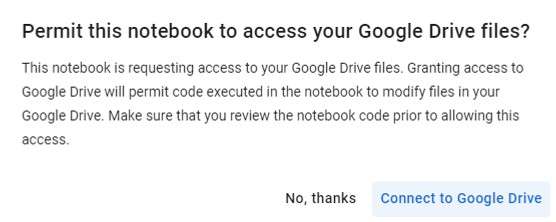

---



# Downloading xView Dataset

The following codes provided by [Ultralytics](https://docs.ultralytics.com/datasets/detect/xview/#dataset-yaml) facilitates automatic and manual download of the xView dataset and conversion to a YOLO compatible format

In [ ]:
# Download script/URL (optional) ---------------------------------------------------------------------------------------
import json
import os
from pathlib import Path

import numpy as np
from PIL import Image
from tqdm import tqdm

from ultralytics.data.utils import autosplit
from ultralytics.utils.ops import xyxy2xywhn


def convert_labels(fname=Path('xView/xView_train.geojson')):
    # Convert xView geoJSON labels to YOLO format
    path = fname.parent
    with open(fname) as f:
        print(f'Loading {fname}...')
        data = json.load(f)

    # Make dirs
    labels = Path(path / 'labels' / 'train')
    os.system(f'rm -rf {labels}')
    labels.mkdir(parents=True, exist_ok=True)

    # xView classes 11-94 to 0-59
    xview_class2index = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 2, -1, 3, -1, 4, 5, 6, 7, 8, -1, 9, 10, 11,
                           12, 13, 14, 15, -1, -1, 16, 17, 18, 19, 20, 21, 22, -1, 23, 24, 25, -1, 26, 27, -1, 28, -1,
                           29, 30, 31, 32, 33, 34, 35, 36, 37, -1, 38, 39, 40, 41, 42, 43, 44, 45, -1, -1, -1, -1, 46,
                           47, 48, 49, -1, 50, 51, -1, 52, -1, -1, -1, 53, 54, -1, 55, -1, -1, 56, -1, 57, -1, 58, 59]

    shapes = {}
    for feature in tqdm(data['features'], desc=f'Converting {fname}'):
        p = feature['properties']
        if p['bounds_imcoords']:
            id = p['image_id']
            file = path / 'train_images' / id
            if file.exists():  # 1395.tif missing
                try:
                    box = np.array([int(num) for num in p['bounds_imcoords'].split(",")])
                    assert box.shape[0] == 4, f'incorrect box shape {box.shape[0]}'
                    cls = p['type_id']
                    cls = xview_class2index[int(cls)]  # xView class to 0-60
                    assert 59 >= cls >= 0, f'incorrect class index {cls}'

                    # Write YOLO label
                    if id not in shapes:
                        shapes[id] = Image.open(file).size
                    box = xyxy2xywhn(box[None].astype(np.float), w=shapes[id][0], h=shapes[id][1], clip=True)
                    with open((labels / id).with_suffix('.txt'), 'a') as f:
                        f.write(f"{cls} {' '.join(f'{x:.6f}' for x in box[0])}\n")  # write label.txt
                except Exception as e:
                    print(f'WARNING: skipping one label for {file}: {e}')

In [ ]:
# Download manually from https://challenge.xviewdataset.org
dir = Path(yaml['path'])  # dataset root dir
# urls = ['https://d307kc0mrhucc3.cloudfront.net/train_labels.zip',  # train labels
#         'https://d307kc0mrhucc3.cloudfront.net/train_images.zip',  # 15G, 847 train images
#         'https://d307kc0mrhucc3.cloudfront.net/val_images.zip']  # 5G, 282 val images (no labels)
# download(urls, dir=dir)

# Convert labels
convert_labels(dir / 'xView_train.geojson')

# Move images
images = Path(dir / 'images')
images.mkdir(parents=True, exist_ok=True)
Path(dir / 'train_images').rename(dir / 'images' / 'train')
Path(dir / 'val_images').rename(dir / 'images' / 'val')

# Split
autosplit(dir / 'images' / 'train')

# Geojson File Read

In the snippet below, you can find the Python script used to format vXiew's geojson file for improved readability. This code was essential for my understanding and utilization of basic information such as tags and image IDs.

In [ ]:
import json

# Replace 'input_geojson.json' with the path to your input GeoJSON file
input_file = 'input_geojson.json'

# Replace 'formatted_geojson.json' with the desired name of the formatted output file
output_file = 'formatted_geojson.json'

def format_geojson(input_file, output_file):
    with open(input_file, 'r') as f:
        geojson_data = json.load(f)

    # Use the `json.dumps` function with indentation to format the GeoJSON
    formatted_geojson = json.dumps(geojson_data, indent=2)

    with open(output_file, 'w') as f:
        f.write(formatted_geojson)

if __name__ == "__main__":
    format_geojson(input_file, output_file)


# Data Parsing
The script below reads the original GeoJSON file, filters its features based on specific type_id values, and then saves the filtered features to a new GeoJSON file. In this example, the filtering criteria are set to 11, 12, and 13, targeting different types of aircraft in the dataset.

In [ ]:
import json

# Specify the input GeoJSON file path
input_geojson_file = 'input.geojson'

# Specify the output GeoJSON file path
output_geojson_file = 'output.geojson'

# Read the input GeoJSON file
with open(input_geojson_file, 'r') as file:
    geojson_data = json.load(file)

# Define a list to store filtered features
filtered_features = []

# Specify the type_id values you want to filter
target_type_ids = [11, 12, 13]

# Iterate through the features and filter based on type_id
for feature in geojson_data['features']:
    if feature['properties'].get('type_id') in target_type_ids:
        filtered_features.append(feature)

# Create a new GeoJSON object with only the filtered features
filtered_geojson = {
    "type": "FeatureCollection",
    "features": filtered_features
}

# Write the filtered GeoJSON object to the output file
with open(output_geojson_file, 'w') as file:
    json.dump(filtered_geojson, file, indent=2)

print(f"Filtered GeoJSON data has been saved to '{output_geojson_file}'.")


You can see the Distribution of imagery includes aircraft labels in the figure below
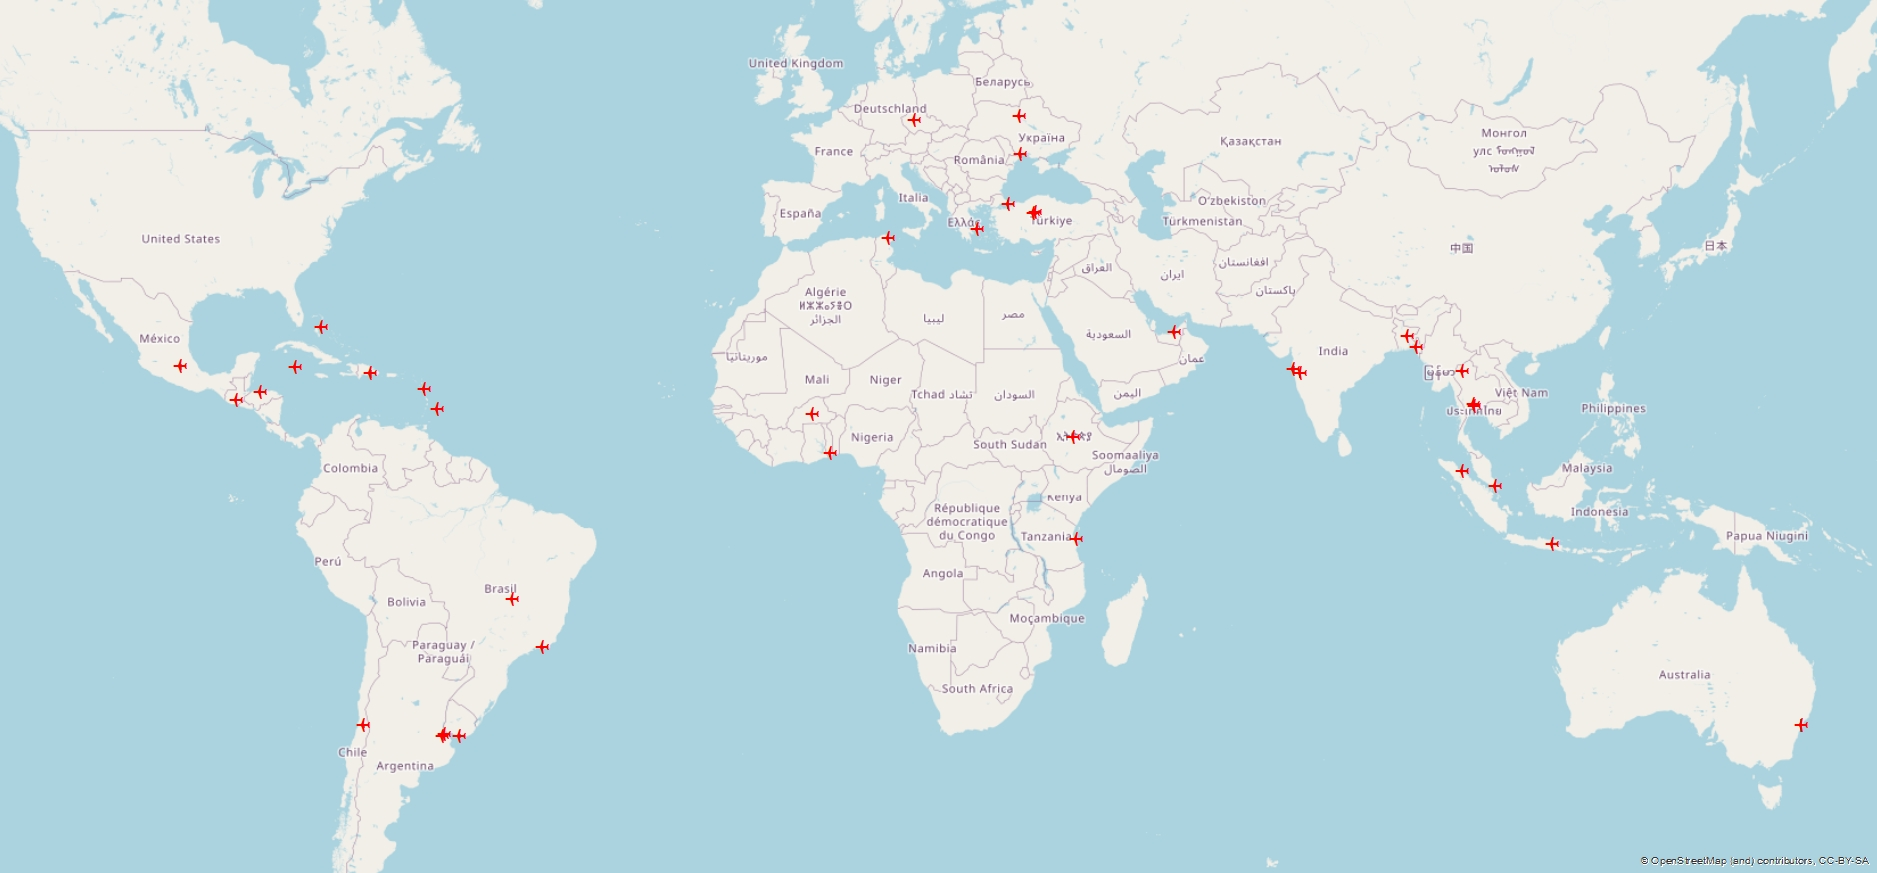

# Converting Labels to YOLO Format
In the next step, we create txt label files conforming to YOLO format from the filtered geojson file.

In [ ]:
import json
import os

geojson_path = 'geojson path'

output_dir = 'output dir where the labels to be stored in'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def geojson_to_yolov5(geojson_path, output_dir):
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)

    for feature in geojson_data['features']:
        if 'geometry' in feature:
            coordinates = feature['geometry']['coordinates']
            type_id = feature['properties']['type_id']
            image_id = feature['properties']['image_id']
            if coordinates and type_id and image_id:
                label_filename = os.path.join(output_dir, image_id.replace('.tif', '.txt'))
                label_id = type_id  # use type_id as label_id
                xmin = min(coordinates[0][0])
                ymin = min(coordinates[0][1])
                xmax = max(coordinates[0][0])
                ymax = max(coordinates[0][1])

                with open(label_filename, 'a') as label_file:
                    label_file.write(f"{label_id} {(xmin + xmax) / 2} {(ymin + ymax) / 2} {xmax - xmin} {ymax - ymin}\n")

if __name__ == '__main__':
    geojson_to_yolov5(geojson_path, output_dir)


# Extracting Pertinent Imagery
Finally, we pull the pertinent imagery according to the labels from the xView training folder.





In [ ]:
import json
import os
import shutil

geojson_path = 'geojson_path'

folder_path = 'folder_path'

target_folder = 'target_folder'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

def copy_tif_files(geojson_path, folder_path, target_folder):
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)

    for feature in geojson_data['features']:
        if 'properties' in feature:
            image_id = feature['properties']['image_id']
            if image_id:
                tif_file_path = os.path.join(folder_path, image_id)
                if os.path.exists(tif_file_path):
                    shutil.copy(tif_file_path, target_folder)
                else:
                    print(f"Warning: '{tif_file_path}' could not be found!")

if __name__ == '__main__':
    copy_tif_files(geojson_path, folder_path, target_folder)

# References



*   If you incorporate the xView dataset into your research or development projects, kindly reference the following paper: *D. Lam, R. Kuzma, K. McGee, S. Dooley, M. Laielli, M. Klaric, Y. Bulatov, and B. McCord, ''XView: Objects in context in overhead imagery,'' 2018, arXiv:1802.07856.*

*   Deepest gratitude to the Defense Innovation Unit (DIU) and the creators of the xView dataset for their invaluable contribution to the computer vision research community. To learn more about the xView dataset and its originators, please visit the following link: https://www.diu.mil/ai-xview-challenge
*   Thanks to Ultralytics for generously sharing their documents and codes related to xView: https://docs.ultralytics.com/datasets/detect/xview/





